In [1]:
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [3]:
data_dir = "../data/fruits 360/fruits-360_dataset/fruits-360"
print("Folder contains:", os.listdir(data_dir))

Folder contains: ['LICENSE', 'papers', 'readme.md', 'Test', 'test-multiple_fruits', 'Training']


In [4]:
labels = os.listdir(data_dir + "/Training")
print("Labels count:", len(labels))
print("Labels:\n", labels)

Labels count: 131
Labels:
 ['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Mango Red', 'Ma

In [5]:
T = transforms.Compose([transforms.ToTensor()])

In [6]:
dataset = ImageFolder(data_dir + "/Training", transform=T)
print("Training dataset size:", len(dataset))
test_dataset = ImageFolder(data_dir + "/Test", transform=T)
print("Test dataset size:", len(test_dataset))

Training dataset size: 67692
Test dataset size: 22688


Label: Apple Golden 1 at 2 dim: torch.Size([3, 100, 100])


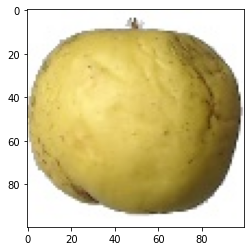

In [7]:
def view_image(img, label):
    print("Label:", dataset.classes[label], "at", label, "dim:", img.shape)
    plt.imshow(img.permute(1, 2, 0))
    return None

img, label = dataset[1099]
view_image(img, label)

In [8]:
val_size = len(dataset) // 10
train_size = len(dataset) - val_size

In [9]:
train_data, val_data = random_split(dataset, [train_size, val_size])
len(train_data), len(val_data), len(test_dataset)

(60923, 6769, 22688)

In [10]:
train_loader = DataLoader(train_data, batch_size=64,
                          shuffle=True, pin_memory=True, 
                          num_workers=6, drop_last=True)
val_loader = DataLoader(val_data, batch_size=64, 
                        pin_memory=True, num_workers=6, 
                        drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=64, 
                         pin_memory=True, num_workers=6)

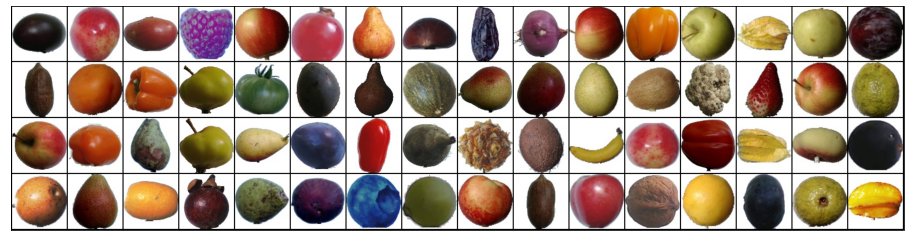

In [11]:
for img, label in train_loader:
    fig, ax = plt.subplots(figsize=(16, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(img, nrow=16).permute(1, 2, 0))
    break

## Feedforward NN 'Base-Model'

In [12]:
def accuracy(yh, y):
    """
    yh: predicted outputs computated by model
    y: real outputs
    """
    _, preds = torch.max(yh, dim=1)
    return torch.tensor(torch.sum(preds == y).item() / len(preds))


class ImageClassificatonEva(nn.Module):
    def training_step(self, batch):
        img, labels = batch
        out = self(img)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        img, labels = batch
        out = self(img)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {"val_loss": loss.detach(), "val_acc": acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_acc = [x["val_acc"] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch: {}, Train_loss: {:.3f}, Val_loss: {:.4f}, Val_acc: {:.3f}".format(
        epoch, result["train_loss"], resutl["val_loss"], result["val_acc"]))

In [23]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit_model(epochs, lr, model, train_loader, val_loader, opt=torch.optim.SGD):
    history = []
    optimizer = opt(model.parameters(), lr)
    
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model, val_loader)
        result["train_loss"] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [24]:
def get_default_device():
    return torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")


def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    def __init__(self, d_loader, device):
        self.d_loader = d_loader
        self.device = device
    
    def __iter__(self):
        for batch in self.d_loader:
            yield to_device(batch, self.device)
    
    def __len__(self):
        return len(self.d_loader)

In [25]:
device = get_default_device()
device

device(type='cuda', index=0)

In [26]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [27]:
input_size = 3 * 100 * 100
output_size = 131

In [28]:
class FCModel(ImageClassificatonEva):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.input_layer = nn.Linear(input_size, 8384)
        self.hidden_1 = nn.Linear(8384, 4192)
        self.hidden_2 = nn.Linear(4192, 2096)
        self.hidden_3 = nn.Linear(2096, 1048)
        self.output_layer = nn.Linear(1048, output_size)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        a1 = F.relu(self.input_layer(x))
        a2 = F.relu(self.hidden_1(a1))
        a3 = F.relu(self.hidden_2(a2))
        a4 = F.relu(self.hidden_3(a3))
        return self.output_layer(a4)

In [29]:
model = to_device(FCModel(input_size, output_size), device)

In [30]:
history = [evaluate(model, val_loader)]

In [31]:
history

[{'val_loss': 4.87581729888916, 'val_acc': 0.01086309552192688}]

In [ ]:
history += fit_model(7, 0.01, model, train_loader, val_loader)